# Домашнее задание по обработке текстов

## Предсказание цены акции по экономическим новостям

Входные данные:
* Новости о компании "Газпром", начиная с 2010 года
* Стоимость акций компании "Газпром" на ММВБ, начиная с 2010 года
    * цена открытия (Open)
    * цена закрытия (ClosingPrice)
    * максимальная цена за день (DailyHigh)
    * минимальная цена за день (DailyLow) 
    * объем бумаг (VolumePcs)


In [1]:
# plots
from matplotlib import pyplot as plt
import seaborn as sns
from pylab import rcParams

from plotly.offline import init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go
init_notebook_mode(connected=True)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%pylab inline
%config InlineBackend.figure_format = 'png'
rcParams['figure.figsize'] = (16, 6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [3]:
df_texts = pd.read_csv('texts.csv', parse_dates=['date'])
df_texts.columns = ['Date', 'Text']
df_texts.head()

,Date,Text
0,2017-09-11,Компания рассчитывает на решение по газовому с...
1,2017-08-11,"Как и предполагал “Ъ”, «Газпром», воспользова..."
2,2017-01-11,Новая редакция американских санкций ставит по...
3,2017-10-30,"Как стало известно “Ъ”, известный на рынке ри..."
4,2017-10-23,"НОВАТЭК, который через пять лет собирается за..."


In [4]:
df_texts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1203 entries, 0 to 1202
Data columns (total 2 columns):
Date    1203 non-null datetime64[ns]
Text    1203 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 18.9+ KB


In [5]:
df_prices = pd.read_csv('gazprom_prices.csv', sep=';', decimal=',', parse_dates=['Date'])
df_prices.head(5)

,Date,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs
0,2017-08-12,133.43,132.60,133.90,132.00,16037970
1,2017-07-12,133.70,133.02,133.87,132.81,18198430
2,2017-06-12,133.33,134.00,134.29,132.91,14641730
3,2017-05-12,133.48,133.65,133.99,132.78,12684800
4,2017-04-12,133.01,133.77,134.00,131.93,17818980


In [6]:
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1988 entries, 0 to 1987
Data columns (total 6 columns):
Date            1988 non-null datetime64[ns]
Open            1964 non-null float64
ClosingPrice    1988 non-null float64
DailyHigh       1986 non-null float64
DailyLow        1986 non-null float64
VolumePcs       1988 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 93.3 KB


In [7]:
df_prices.describe()

,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs
count,1964.000000,1988.000000,1986.000000,1986.000000,1.988000e+03
mean,151.638396,151.535669,153.266153,149.851566,4.432934e+07
std,24.067928,23.939595,24.276879,23.594899,2.424019e+07
min,107.230000,107.170000,109.200000,106.500000,7.017140e+06
25%,135.897500,135.637500,136.992500,134.510000,2.731040e+07
50%,145.720000,145.800000,147.360000,144.225000,3.796464e+07
75%,162.645000,162.762500,164.372500,160.475000,5.552437e+07
max,243.520000,244.000000,247.470000,241.770000,2.024663e+08


### Часть 1. Вводная

Проведите предобработку текстов: если считаете нужным, выполните токенизацию, приведение к нижнему регистру, лемматизацию и/или стемминг. Ответьте на следующие вопросы:
* Есть ли корреляция между средней длинной текста за день и ценой закрытия?
* Есть ли корреляция между количеством упоминаний Алексея Миллера  и ценой закрытия? Учтите разные варианты написания имени.
* Упоминаний какого газопровода в статьях больше: 
    * "северный поток"
    * "турецкий поток"?
* О каких санкциях пишут в статьях?

In [8]:
def price_increased(x):
    return 1 if x['ClosingPrice'] >= x['Open'] else 0

import string

from nltk.corpus import stopwords
stop_words = stopwords.words('russian') + ['-', '-', 'это', 'наш', 'также',
                                           'т', 'д', 'тд', 'что', 'так', 'вот',
                                           'быть', 'как', 'в', '—', 'к', 'на', 'который']

def remove_stop_words(x):
    return ' '.join([word for word in x.split() if word not in (stop_words)])

from pymystem3 import Mystem
lemmatizer = Mystem()

def lemmatize(text):
    return ''.join(lemmatizer.lemmatize(text)).strip()

In [9]:
df_all = pd.merge(df_texts, df_prices, on=['Date'], how='inner')
df_all['TextProcessed'] = df_all['Text'].str.lower()
df_all['TextProcessed'] = df_all['TextProcessed'].str.translate(dict.fromkeys(map(ord, string.punctuation)))
df_all['TextProcessed'] = df_all['TextProcessed'].apply(lemmatize)
df_all['TextProcessed'] = df_all['TextProcessed'].apply(remove_stop_words)
df_all.head()

,Date,Text,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs,TextProcessed
0,2017-09-11,Компания рассчитывает на решение по газовому с...,132.31,131.50,132.82,131.14,33869650,компания рассчитывать решение газовый спор укр...
1,2017-08-11,"Как и предполагал “Ъ”, «Газпром», воспользова...",132.00,132.30,133.94,131.58,39381960,предполагать “ъ” «газпром» воспользоваться жал...
2,2017-01-11,Новая редакция американских санкций ставит по...,126.40,126.50,126.89,125.97,18232550,новый редакция американский санкция ставить уг...
3,2017-10-30,"Как стало известно “Ъ”, известный на рынке ри...",125.96,125.98,126.93,125.53,19263340,становиться известно “ъ” известный рынок рискм...
4,2017-10-23,"НОВАТЭК, который через пять лет собирается за...",127.05,126.80,127.47,126.37,17308800,новатэк пять год собираться запускать камчатка...


Есть ли корреляция между средней длинной текста за день и ценой закрытия?

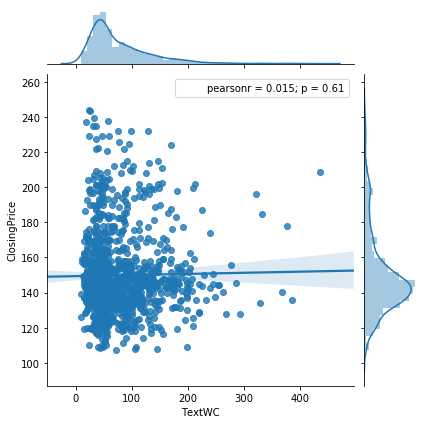

In [10]:
df_wc = df_all.copy()
df_wc['TextWC'] = df_wc['TextProcessed'].str.split().apply(lambda x: len(x))
sns.jointplot(data=df_wc, x='TextWC', y='ClosingPrice', kind='reg')

Есть ли корреляция между количеством упоминаний Алексея Миллера и ценой закрытия? Учтите разные варианты написания имени.

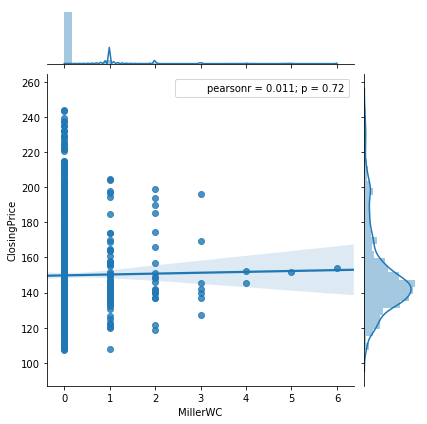

In [11]:
import re
df_miller = df_all.copy()
df_miller['MillerWC'] = df_miller['TextProcessed'].str.count('миллер')
sns.jointplot(data=df_miller, x='MillerWC', y='ClosingPrice', kind='reg')

Упоминаний какого газопровода в статьях больше: 
* "северный поток"
* "турецкий поток"?

In [12]:
print('северный поток', df_all['TextProcessed'].str.count('северный поток').sum())
print('турецкий поток', df_all['TextProcessed'].str.count('турецкий поток').sum())

северный поток 15
турецкий поток 39


О каких санкциях пишут в статьях?

In [13]:
from pymorphy2 import MorphAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range=(2, 2))
cv.fit(df_all['TextProcessed'])

morph = MorphAnalyzer()

for s in cv.vocabulary_:
    w1, w2 = s.split()
    if w2 == 'санкция' and 'ADJF' in morph.parse(w1)[0].tag:
            print(s)

западный санкция
антироссийский санкция
секторальный санкция
персональный санкция
американский санкция
экономический санкция
международный санкция
штрафной санкция
финансовый санкция
очередной санкция


## Часть 2. Классификационная
Вам предстоит решить следующую задачу: по текстам новостей за день определить, вырастет или понизится цена закрытия.
Для этого:
* бинаризуйте признак "цена закрытия":  новый признак ClosingPrice_bin равен 1, если по сравнению со вчера цена не упала, и 0 – в обратном случаея;
* составьте бучающее и тестовое множество: данные до начала 2016 года используются для обучения, данные с 2016 года и позже – для тестирования.

Таким образом, в каждлый момент времени мы знаем: 
* ClosingPrice_bin – бинарый целевой признак
* слова из статей, опубликованных в этот день – объясняющие признаки

В этой части задания вам нужно сделать baseline алгоритм и попытаться его улучшить в следующей части. 

Используйте любой известный вам алгоритм классификации текстов для того, Используйте $tf-idf$ преобразование, сингулярное разложение, нормировку признакого пространства и любые другие техники обработки данных, которые вы считаете нужным. Используйте accuracy и F-measure для оценки качества классификации. Покажите, как  $tf-idf$ преобразование или сингулярное разложение или любая другая использованная вами техника влияет на качество классификации.
Если у выбранного вами алгоритма есть гиперпараметры (например, $\alpha$ в преобразовании Лапласа для метода наивного Байеса), покажите, как изменение гиперпараметра влияет на качество классификации.

In [14]:
df_all['ClosingPrice_bin'] = df_all.apply(price_increased, axis=1)
df_all.head()

,Date,Text,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs,TextProcessed,ClosingPrice_bin
0,2017-09-11,Компания рассчитывает на решение по газовому с...,132.31,131.50,132.82,131.14,33869650,компания рассчитывать решение газовый спор укр...,0
1,2017-08-11,"Как и предполагал “Ъ”, «Газпром», воспользова...",132.00,132.30,133.94,131.58,39381960,предполагать “ъ” «газпром» воспользоваться жал...,1
2,2017-01-11,Новая редакция американских санкций ставит по...,126.40,126.50,126.89,125.97,18232550,новый редакция американский санкция ставить уг...,1
3,2017-10-30,"Как стало известно “Ъ”, известный на рынке ри...",125.96,125.98,126.93,125.53,19263340,становиться известно “ъ” известный рынок рискм...,1
4,2017-10-23,"НОВАТЭК, который через пять лет собирается за...",127.05,126.80,127.47,126.37,17308800,новатэк пять год собираться запускать камчатка...,0


In [15]:
df_train = df_all[df_all['Date'] < pd.Timestamp('2016')].reset_index(drop=True)
df_test = df_all[df_all['Date'] >= pd.Timestamp('2016')].reset_index(drop=True)
df_train.shape, df_test.shape

((901, 9), (258, 9))

In [16]:
from sklearn.metrics import *

In [17]:
def print_score(y_test, y_pred):
    print("Accuracy:    {0:.2f}".format(accuracy_score(y_test, y_pred)))  
    print("F1-measure:  {0:.2f}".format(f1_score(y_test, y_pred)))
    print("Precision:   {0:.2f}".format(precision_score(y_test, y_pred)))
    print("Recall:      {0:.2f}".format(recall_score(y_test, y_pred)))
    
    print(classification_report(df_test['ClosingPrice_bin'], y_pred))

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import *
from sklearn.feature_extraction.text import *

clf = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),    
    ('clf', MultinomialNB()),
])

params = {
    'vectorizer__ngram_range': [(1, 1), (1, 3), (2, 2), (2, 3), (2, 4)],
    'tfidf__use_idf': (True, False),    
    'clf__alpha': (0.001, 0.01, 0.1, 1, 2)
}

clf = GridSearchCV(clf, params, scoring='f1', cv=5, n_jobs=-1)
clf.fit(df_train['TextProcessed'], df_train['ClosingPrice_bin'])
print(clf.best_estimator_)
print_score(df_test['ClosingPrice_bin'], clf.best_estimator_.predict(df_test['TextProcessed']))

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
       ...ear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True))])
Accuracy:    0.49
F1-measure:  0.41
Precision:   0.44
Recall:      0.38
             precision    recall  f1-score   support

          0       0.53      0.59      0.56       140
          1       0.44      0.38      0.41       118

avg / total       0.49      0.49      0.49       258



## Часть 3. Творческая
Придумайте и попытайтесь сделать еще что-нибудь, чтобы улучшить качество классификации. 
Направления развития:
* Морфологический признаки: 
    * использовать в качестве признаков только существительные или только именованные сущности;
* Модели скрытых тем:
    * использовать в качестве признаков скрытые темы;
    * использовать в качестве признаков динамические скрытые темы 
    пример тут: (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/dtm_example.ipynb)
* Синтаксические признаки:
    * использовать SOV-тройки в качестве признаков
    * кластеризовать SOV-тройки по эмбеддингам глаголов (обученные word2vec модели можно скачать отсюда: (http://rusvectores.org/ru/models/) и использовать только центроиды кластеров в качестве признаков
* что-нибудь еще     

## Fasttext

In [19]:
import fasttext

with open('train_raw.txt', 'w') as ftrain:
    for i, row in df_train.iterrows():
        ftrain.write('%s __label__%s\n' % (re.sub('\n', ' ', row['Text']), row['ClosingPrice_bin']))
                
with open('test_raw.txt', 'w') as ftest:
    for i, row in df_test.iterrows():
        ftest.write('%s __label__%s\n' % (re.sub('\n', ' ', row['Text']), row['ClosingPrice_bin']))
        
classifier = fasttext.supervised('train_raw.txt', 'model')
result = classifier.test('test_raw.txt')

print('Raw Text:')
print('Precision', result.precision)
print('Recall', result.recall)

# And now on preprocessed

with open('train_processed.txt', 'w') as ftrain:
    for i, row in df_train.iterrows():
        ftrain.write('%s __label__%s\n' % (row['TextProcessed'], row['ClosingPrice_bin']))
                
with open('test_processed.txt', 'w') as ftest:
    for i, row in df_test.iterrows():
        ftest.write('%s __label__%s\n' % (row['TextProcessed'], row['ClosingPrice_bin']))
        
classifier = fasttext.supervised('train_processed.txt', 'model')

result = classifier.test('test_processed.txt')

print('Processed Text:')
print('Precision', result.precision)
print('Recall', result.recall)

Raw Text:
Precision 0.5503875968992248
Recall 0.5503875968992248
Processed Text:
Precision 0.5193798449612403
Recall 0.5193798449612403


## CNN

In [21]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Embedding, Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout

Using TensorFlow backend.


In [160]:
TEXT_LENGTH = 200
VOCABULARY_SIZE = 25000
EMBEDDING_DIM = 128
batch_size = 32

nb_epoch = 20

In [161]:
tokenizer = Tokenizer(num_words=VOCABULARY_SIZE)
tokenizer.fit_on_texts(df_train['Text'])

X_train = pad_sequences(tokenizer.texts_to_sequences(df_train['Text']), maxlen=TEXT_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(df_test['Text']), maxlen=TEXT_LENGTH)

y_train = to_categorical(df_train['ClosingPrice_bin'], 2)
y_test = to_categorical(df_test['ClosingPrice_bin'], 2)

print('Shape of data tensor:', X_train.shape)
print('Shape of label tensor:', y_train.shape)
print('Shape of data tensor:', X_test.shape)
print('Shape of label tensor:', y_test.shape)

Shape of data tensor: (901, 200)
Shape of label tensor: (901, 2)
Shape of data tensor: (258, 200)
Shape of label tensor: (258, 2)


In [162]:
embedding_layer = Embedding(VOCABULARY_SIZE, EMBEDDING_DIM, input_length=TEXT_LENGTH, trainable=True)
sequence_input = Input(shape=(TEXT_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 4, activation='relu')(embedded_sequences)
# x = MaxPooling1D(4)(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
preds = Dense(2, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['acc'])

model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size, validation_split=0.1)

Train on 810 samples, validate on 91 samples
Epoch 1/20
810/810 [==============================] - 4s 5ms/step - loss: 0.6955 - acc: 0.5136 - val_loss: 0.6990 - val_acc: 0.4396
Epoch 2/20
810/810 [==============================] - 2s 2ms/step - loss: 0.6750 - acc: 0.6049 - val_loss: 0.6945 - val_acc: 0.5385
Epoch 3/20
810/810 [==============================] - 2s 2ms/step - loss: 0.6505 - acc: 0.6975 - val_loss: 0.6947 - val_acc: 0.5385
Epoch 4/20
810/810 [==============================] - 2s 3ms/step - loss: 0.6210 - acc: 0.8407 - val_loss: 0.6927 - val_acc: 0.5055
Epoch 5/20
810/810 [==============================] - 2s 3ms/step - loss: 0.5786 - acc: 0.9210 - val_loss: 0.7024 - val_acc: 0.5495
Epoch 6/20
810/810 [==============================] - 2s 3ms/step - loss: 0.5213 - acc: 0.9531 - val_loss: 0.7014 - val_acc: 0.5495
Epoch 7/20
810/810 [==============================] - 2s 3ms/step - loss: 0.4467 - acc: 0.9531 - val_loss: 0.7098 - val_acc: 0.4725
Epoch 8/20
810/810 [===========

In [163]:
predictions = model.predict(X_test)

def probs_to_classes(probas):
    classes = np.zeros(probas.shape, dtype=np.int)
    for i, row in enumerate(probas):
        classes[i, np.argmax(row)] = 1
    return classes

y_pred = probs_to_classes(predictions)

print_score(y_test[:, 1], y_pred[:, 1])

Accuracy:    0.48
F1-measure:  0.41
Precision:   0.42
Recall:      0.40
             precision    recall  f1-score   support

          0       0.52      0.54      0.53       140
          1       0.42      0.40      0.41       118

avg / total       0.47      0.48      0.48       258



## NN

In [151]:
MAX_FEATURES = 5000
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(df_train['Text'])

X_train = tokenizer.sequences_to_matrix(tokenizer.texts_to_sequences(df_train['Text']), mode='count')
X_test = tokenizer.sequences_to_matrix(tokenizer.texts_to_sequences(df_test['Text']), mode='count')

y_train = to_categorical(df_train['ClosingPrice_bin'], 2)
y_test = to_categorical(df_test['ClosingPrice_bin'], 2)

In [158]:
model = Sequential()
model.add(Dense(128, input_shape=(MAX_FEATURES,), activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size, validation_split=0.1)

Train on 810 samples, validate on 91 samples
Epoch 1/20
810/810 [==============================] - 2s 2ms/step - loss: 0.7166 - acc: 0.4790 - val_loss: 0.7054 - val_acc: 0.5165
Epoch 2/20
810/810 [==============================] - 0s 214us/step - loss: 0.3860 - acc: 0.9395 - val_loss: 0.7399 - val_acc: 0.4945
Epoch 3/20
810/810 [==============================] - 0s 207us/step - loss: 0.2135 - acc: 0.9852 - val_loss: 0.8150 - val_acc: 0.5385
Epoch 4/20
810/810 [==============================] - 0s 209us/step - loss: 0.1094 - acc: 0.9951 - val_loss: 0.9168 - val_acc: 0.5275
Epoch 5/20
810/810 [==============================] - 0s 203us/step - loss: 0.0555 - acc: 1.0000 - val_loss: 1.0102 - val_acc: 0.4945
Epoch 6/20
810/810 [==============================] - 0s 205us/step - loss: 0.0302 - acc: 1.0000 - val_loss: 1.0694 - val_acc: 0.4945
Epoch 7/20
810/810 [==============================] - 0s 204us/step - loss: 0.0186 - acc: 1.0000 - val_loss: 1.1856 - val_acc: 0.4945
Epoch 8/20
810/810 

In [159]:
predictions = model.predict(X_test)

def probs_to_classes(probas):
    classes = np.zeros(probas.shape, dtype=np.int)
    for i, row in enumerate(probas):
        classes[i, np.argmax(row)] = 1
    return classes

y_pred = probs_to_classes(predictions)

print_score(y_test[:, 1], y_pred[:, 1])

Accuracy:    0.54
F1-measure:  0.48
Precision:   0.50
Recall:      0.47
             precision    recall  f1-score   support

          0       0.57      0.60      0.59       140
          1       0.50      0.47      0.48       118

avg / total       0.54      0.54      0.54       258

